# Analyze a single radius range for tau

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
if '..' not in sys.path: sys.path.append('..')
from f_ring_util import (compute_corrected_ew, 
                         compute_corrected_ew_col,
                         fit_hg_phase_function, 
                         hg_func,
                         print_hg_params)
pd.set_option('display.max_rows', None)

In [2]:
# Define variables

# directory of dumped EW csv files
# dump_ew_dir = '/Users/mlessard/REU_2022/data/dump_ew_csv/'
dump_ew_dir = '/seti/src/f-ring/data_files/'

radii = [139470, 140965]

radius = 140220-50
new_col_name = f'Normal EW{radius}'

size = 0 # slice/step size of the csv file, currently only have 0
radial_step = 10

# degrees within 90 (incidence angle) to cut off/get rid of observations
eqx_cutoff = 1.5

# list outlier obsids
outliers = ['ISS_091RF_FMOVIE003_PRIME', 'ISS_107RF_FMOVIE002_PRIME', 'ISS_189RF_FMOVIE001_PRIME']
outliers_inner = ['ISS_177RF_FRSTRCHAN001_PRIME_2', 'ISS_201RF_FMOVIE001_PRIME_2', 'ISS_079RF_FRINGMRLF002_PRIME', 'ISS_235RF_FMOVIE001_PRIME']
outliers_outer = []#'ISS_051RI_LPMRDFMOV001_PRIME']

ms=20
alpha=0.7

In [3]:
# Define functions to process data

def remove_eqx(orig_obsdata, eqx_cutoff):
    #remove EQX observations
    #orig_obsdata: original pandas dataframe
    #returns: obsdata (EQX observations removed)
    
    good_i = np.abs(orig_obsdata['Incidence']-90) > eqx_cutoff
    obsdata = orig_obsdata[good_i]
    print('Removed EQX OBSIDs:', set(orig_obsdata[~good_i].groupby('Observation').indices))
    print('Unique observation names:', len(obsdata))
    print()
    
    return obsdata

def remove_outliers(obsdata, outlier_obs):
    #remove 3 outliers from ~phase 50-60 before fitting for tau
    #(located by hand, removing from all 3 by observation name)
    
    for obsid in outlier_obs:
        #drop row containing outlier ob
        obsdata = obsdata[obsdata.index != obsid]
            
    print('Removed outlier OBSIDs:', outlier_obs)
    print('Unique observation names:', len(obsdata))
    print()
    return obsdata


In [4]:
# Read in the CSV file

#get the full-width image data
full_img_filepath = f'{dump_ew_dir}ew_stats_{radii[0]}_{radii[1]}_{size}_{radial_step}.csv'
full_orig_obsdata = pd.read_csv(full_img_filepath, parse_dates=['Date'], index_col='Observation')

#calculate mu, mu0 
full_orig_obsdata['Mu'] = np.abs(np.cos(np.radians(full_orig_obsdata['Mean Emission'])))
full_orig_obsdata['Mu0'] = np.abs(np.cos(np.radians(full_orig_obsdata['Incidence'])))

In [5]:
#print initial statistics
print('** ORIGINAL SUMMARY STATISTICS **')
print('Unique observation names:', len(full_orig_obsdata.groupby('Observation')))
print('Total slices:', len(full_orig_obsdata))
print('Starting date:', full_orig_obsdata['Date'].min())
print('Ending date:', full_orig_obsdata['Date'].max())
print('Time span:', full_orig_obsdata['Date'].max()-full_orig_obsdata['Date'].min())
print()

print(full_img_filepath)

** ORIGINAL SUMMARY STATISTICS **
Unique observation names: 151
Total slices: 151
Starting date: 2004-06-20 20:03:28
Ending date: 2017-09-06 11:47:07
Time span: 4825 days 15:43:39

/seti/src/f-ring/data_files/ew_stats_139470_140965_0_10.csv


In [6]:
#remove EQX observations
removed_eqx_obsdata = remove_eqx(full_orig_obsdata, eqx_cutoff)

#remove outliers
obsdata = remove_outliers(removed_eqx_obsdata, outliers)
obsdata = remove_outliers(obsdata, outliers_inner)
obsdata = remove_outliers(obsdata, outliers_outer)

#print initial statistics
print('** FINAL SUMMARY STATISTICS **')
print('Unique observation names:', len(obsdata.groupby('Observation')))
print('Total slices:', len(obsdata))
print('Starting date:', obsdata['Date'].min())
print('Ending date:', obsdata['Date'].max())
print('Time span:', obsdata['Date'].max()-obsdata['Date'].min())
print()

Removed EQX OBSIDs: {'ISS_112RF_FMOVIE002_PRIME_1', 'ISS_111RF_FMOVIE002_PRIME', 'ISS_110RF_FMOVIE002_PRIME', 'ISS_112RF_FMOVIE002_PRIME_2', 'ISS_114RF_FMOVIEEQX001_PRIME', 'ISS_115RF_FMOVIEEQX001_PRIME'}
Unique observation names: 145

Removed outlier OBSIDs: ['ISS_091RF_FMOVIE003_PRIME', 'ISS_107RF_FMOVIE002_PRIME', 'ISS_189RF_FMOVIE001_PRIME']
Unique observation names: 142

Removed outlier OBSIDs: ['ISS_177RF_FRSTRCHAN001_PRIME_2', 'ISS_201RF_FMOVIE001_PRIME_2', 'ISS_079RF_FRINGMRLF002_PRIME', 'ISS_235RF_FMOVIE001_PRIME']
Unique observation names: 138

Removed outlier OBSIDs: []
Unique observation names: 138

** FINAL SUMMARY STATISTICS **
Unique observation names: 138
Total slices: 138
Starting date: 2004-06-20 20:03:28
Ending date: 2017-09-06 11:47:07
Time span: 4825 days 15:43:39



<h1> Optimize Tau for Low-Phase Observations </h1>

In [7]:
# Find "small" (<6) e or i
low_phase_mask = obsdata['Mean Phase'] <= 60
low_phase_obsdata = obsdata[low_phase_mask]
lp_low_e_mask = np.abs(low_phase_obsdata['Mean Emission']-90) < 6
lp_low_i_mask = np.abs(low_phase_obsdata['Incidence']-90) < 6
lp_low_ei_mask = lp_low_e_mask | lp_low_i_mask

low_e_mask = np.abs(obsdata['Mean Emission']-90) < 6
low_i_mask = np.abs(obsdata['Incidence']-90) < 6
low_ei_mask = low_e_mask | low_i_mask

In [8]:
# Find the optimal tau to minimize scatter
# use the low-phase data to calculate
best_tau = None
best_slope = 1e38
for tau in np.arange(0.000, 0.300, 0.001):
    corrected_ew = compute_corrected_ew_col(low_phase_obsdata, col_tau=(new_col_name, tau)) 
    
    coeff = np.polyfit(low_phase_obsdata['Mu0'], corrected_ew, 1)
    if abs(coeff[0]) < best_slope:
        best_slope = abs(coeff[0])
        best_tau = tau
    print(f'Tau {tau:.3f} - Slope: {coeff[0]:8.5f}')

print()
print(f'** Best Tau: {best_tau:.3f}')

Tau 0.000 - Slope:  0.01821
Tau 0.001 - Slope:  0.01817
Tau 0.002 - Slope:  0.01812
Tau 0.003 - Slope:  0.01808
Tau 0.004 - Slope:  0.01803
Tau 0.005 - Slope:  0.01799
Tau 0.006 - Slope:  0.01794
Tau 0.007 - Slope:  0.01790
Tau 0.008 - Slope:  0.01785
Tau 0.009 - Slope:  0.01780
Tau 0.010 - Slope:  0.01775
Tau 0.011 - Slope:  0.01770
Tau 0.012 - Slope:  0.01765
Tau 0.013 - Slope:  0.01760
Tau 0.014 - Slope:  0.01755
Tau 0.015 - Slope:  0.01750
Tau 0.016 - Slope:  0.01744
Tau 0.017 - Slope:  0.01739
Tau 0.018 - Slope:  0.01734
Tau 0.019 - Slope:  0.01728
Tau 0.020 - Slope:  0.01722
Tau 0.021 - Slope:  0.01717
Tau 0.022 - Slope:  0.01711
Tau 0.023 - Slope:  0.01705
Tau 0.024 - Slope:  0.01699
Tau 0.025 - Slope:  0.01693
Tau 0.026 - Slope:  0.01687
Tau 0.027 - Slope:  0.01681
Tau 0.028 - Slope:  0.01675
Tau 0.029 - Slope:  0.01669
Tau 0.030 - Slope:  0.01663
Tau 0.031 - Slope:  0.01656
Tau 0.032 - Slope:  0.01650
Tau 0.033 - Slope:  0.01643
Tau 0.034 - Slope:  0.01637
Tau 0.035 - Slope:  

In [9]:
#add column with corrected EW (using best-fit tau)

#total corrected EW:
total_c_ew = compute_corrected_ew_col(obsdata, col_tau=(new_col_name, best_tau)) 

#add values as additional columns to dataframes
obsdata['Total C EW'] = total_c_ew
low_phase_obsdata = obsdata[low_phase_mask]

In [10]:
#calculate means of uncorrected (UC) vs. corrected (C) low-phase data, display

print()
print('Uncorrected Low Phase:')
uc_mean_low = np.mean(low_phase_obsdata[new_col_name][lp_low_ei_mask])
uc_mean_notlow = np.mean(low_phase_obsdata[new_col_name][~lp_low_ei_mask])
print(f'Mean Normal EW Low E/I:  {uc_mean_low:.5f}')
print(f'Mean Normal EW High E/I: {uc_mean_notlow:.5f}')
print(f'High/Low: {uc_mean_notlow/uc_mean_low:.5f}')
print()

lp_corrected_ew = low_phase_obsdata['Total C EW']
mean_low = np.mean(lp_corrected_ew[lp_low_ei_mask])
mean_notlow = np.mean(lp_corrected_ew[~lp_low_ei_mask])
print(f'Corrected (tau={best_tau:.3f}) Low Phase:')
print(f'Mean Normal EW Low E/I:  {mean_low:.5f}')
print(f'Mean Normal EW High E/I: {mean_notlow:.5f}')
print(f'High/Low: {mean_notlow/mean_low:.5f}')

print()
print('Overall change due to Tau:')
print(f'Mean Normal EW Low E/I: {mean_low/uc_mean_low:.5f}')
print(f'Mean Normal EW Other:   {mean_notlow/uc_mean_notlow:.5f}')


Uncorrected Low Phase:
Mean Normal EW Low E/I:  0.00565
Mean Normal EW High E/I: 0.00965
High/Low: 1.70833

Corrected (tau=0.163) Low Phase:
Mean Normal EW Low E/I:  0.01822
Mean Normal EW High E/I: 0.01576
High/Low: 0.86454

Overall change due to Tau:
Mean Normal EW Low E/I: 3.22582
Mean Normal EW Other:   1.63249


In [11]:
# Find H-G phase curve for full dataset
corrected_ew = obsdata['Total C EW']

uc_hg_params, uc_hg_used_data, uc_hg_std = fit_hg_phase_function(2, None, obsdata, 
                                                                 col_tau=(f'Normal EW{radius}', None),
                                                                 verbose=False)
print('Uncorrected H-G params:')
print_hg_params(uc_hg_params, indent=2)
print(f'  Standard deviation: {uc_hg_std:.5f}')

hg_params, hg_used_data, hg_std = fit_hg_phase_function(2, None, obsdata, col_tau=('Total C EW', None),
                                                        verbose=False)
print()
print(f'Corrected (tau={best_tau:.3f}) params:')
print_hg_params(hg_params, indent=2)
print(f'  Standard deviation: {hg_std:.5f}')

Uncorrected H-G params:
  g1 =  0.550 / scale1 =  0.044 / weight1 = 0.734
  g2 =  0.115 / scale2 =  0.016 / weight2 = 0.266
  Standard deviation: 0.23598

Corrected (tau=0.163) params:
  g1 =  0.531 / scale1 =  0.077 / weight1 = 0.789
  g2 =  0.003 / scale2 =  0.021 / weight2 = 0.211
  Standard deviation: 0.20609


[0.01820952 0.00397148]
[4.08214047e-05 1.67746705e-02]


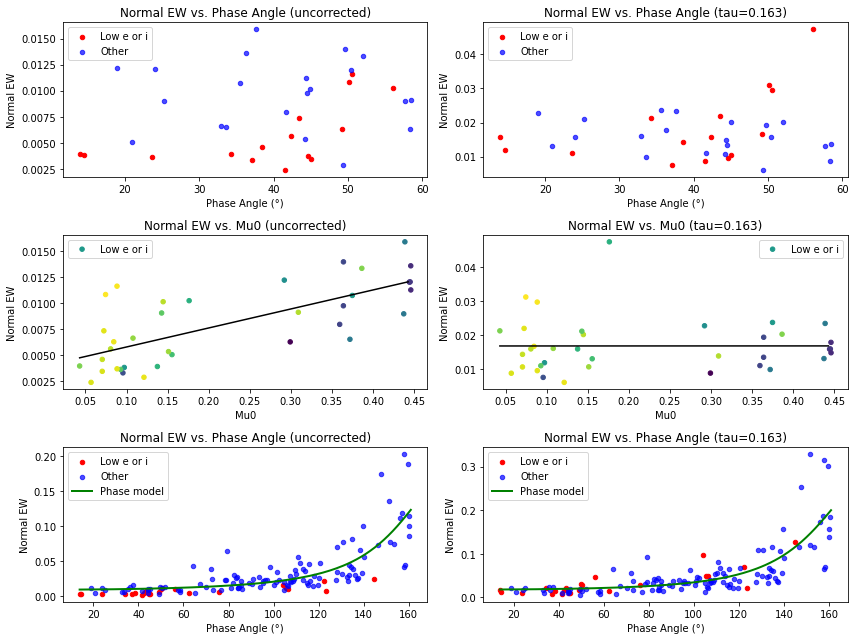

In [12]:
# Plot results
plt.figure(figsize=(12,9))
plt.subplot(3, 2, 1)
plt.scatter(low_phase_obsdata['Mean Phase'][lp_low_ei_mask], 
            low_phase_obsdata[new_col_name][lp_low_ei_mask], 
            s=ms, c='red', label='Low e or i')
plt.scatter(low_phase_obsdata['Mean Phase'][~lp_low_ei_mask], 
            low_phase_obsdata[new_col_name][~lp_low_ei_mask], 
            s=ms, alpha=alpha, c='blue', label='Other')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
plt.title('Normal EW vs. Phase Angle (uncorrected)')

plt.subplot(3, 2, 2)
plt.scatter(low_phase_obsdata['Mean Phase'][lp_low_ei_mask], 
            lp_corrected_ew[lp_low_ei_mask], 
            s=ms, c='red', label='Low e or i')
plt.scatter(low_phase_obsdata['Mean Phase'][~lp_low_ei_mask], 
            lp_corrected_ew[~lp_low_ei_mask], 
            s=ms, alpha=alpha, c='blue', label='Other')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
plt.title(f'Normal EW vs. Phase Angle (tau={best_tau:.3f})')

plt.subplot(3, 2, 3)
plt.scatter(low_phase_obsdata['Mu0'], 
            low_phase_obsdata[new_col_name], 
            s=ms, label='Low e or i', c=low_phase_obsdata['Mean Emission'])
coeff = np.polyfit(low_phase_obsdata['Mu0'], low_phase_obsdata[new_col_name], 1)
print(coeff)
mu0range = np.arange(low_phase_obsdata['Mu0'].min(), low_phase_obsdata['Mu0'].max(), 0.01)
fit = np.polyval(coeff, mu0range)
plt.plot(mu0range, fit, '-', c='k')
plt.legend()
plt.xlabel('Mu0')
plt.ylabel('Normal EW')
plt.title('Normal EW vs. Mu0 (uncorrected)')

plt.subplot(3, 2, 4)
plt.scatter(low_phase_obsdata['Mu0'], 
            lp_corrected_ew, 
            s=ms, label='Low e or i', c=low_phase_obsdata['Mean Emission'])
coeff = np.polyfit(low_phase_obsdata['Mu0'], lp_corrected_ew, 1)
mu0range = np.arange(low_phase_obsdata['Mu0'].min(), low_phase_obsdata['Mu0'].max(), 0.01)
fit = np.polyval(coeff, mu0range)
print(coeff)
plt.plot(mu0range, fit, '-', c='k')
plt.legend()
plt.xlabel('Mu0')
plt.ylabel('Normal EW')
plt.title(f'Normal EW vs. Mu0 (tau={best_tau:.3f})')

plt.subplot(3, 2, 5)
plt.scatter(obsdata['Mean Phase'][low_ei_mask], 
            obsdata[new_col_name][low_ei_mask], 
            s=ms, c='red', label='Low e or i')
plt.scatter(obsdata['Mean Phase'][~low_ei_mask], 
            obsdata[new_col_name][~low_ei_mask], 
            s=ms, alpha=alpha, c='blue', label='Other')
xrange = np.arange(obsdata['Mean Phase'].min(), obsdata['Mean Phase'].max()+1)
uc_hg_phase_model = hg_func(uc_hg_params, np.radians(xrange))
plt.plot(xrange, uc_hg_phase_model, '-', color='green', lw=2, label='Phase model')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
plt.title('Normal EW vs. Phase Angle (uncorrected)')

plt.subplot(3, 2, 6)
plt.scatter(obsdata['Mean Phase'][low_ei_mask], 
            corrected_ew[low_ei_mask], 
            s=ms, c='red', label='Low e or i')
plt.scatter(obsdata['Mean Phase'][~low_ei_mask], 
            corrected_ew[~low_ei_mask], 
            s=ms, alpha=alpha, c='blue', label='Other')
xrange = np.arange(obsdata['Mean Phase'].min(), obsdata['Mean Phase'].max()+1)
hg_phase_model = hg_func(hg_params, np.radians(xrange))
plt.plot(xrange, hg_phase_model, '-', color='green', lw=2, label='Phase model')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
plt.title(f'Normal EW vs. Phase Angle (tau={best_tau:.3f})')
plt.tight_layout()
plt.show()

In [13]:
low_phase_obsdata[low_phase_obsdata[new_col_name] > 0.017]

,Slice#,Num Data,Date,Min Long,Max Long,Min Res,Max Res,Mean Res,Min Phase,Max Phase,...,EW140950 STD,Normal EW140950,Normal EW140950 STD,EW140960,EW140960 STD,Normal EW140960,Normal EW140960 STD,Mu,Mu0,Total C EW
Observation,,,,,,,,,,,,,,,,,,,,,
